In [86]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import os
import matplotlib.colors

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
# !conda install -q -c conda-forge folium=0.5.0 --yes # uncomment if library not installed
import folium
# !pip install -q python-zillow # uncomment if library not installed
# import zillow
# !pip install -q shapely # uncomment if library not installed
# from shapely.geometry import shape, Point
import json
from matplotlib import cm


In [2]:
!ls ../Datasets/

Code Legends		      job_listings.csv
_DS_Store		      labor_market_statistics.csv
employment_by_occupation.csv  lse_historical_data.csv
immigrant_statistics.csv      uk_bill_data.csv


In [291]:
# public job listings (see onet_code_legend.csv) and associated company info (see soc_code_legend.csv)
df1 = pd.read_csv('../Datasets/job_listings.csv', index_col=5, parse_dates=True) 
df1['delete_date'] = pd.to_datetime(df1['delete_date'])
df1.drop(columns=['url', 'last_updated', 'last_checked', 'ticker_start_date', 'ticker_end_date',
                 'title', 'company_name', 'stock_exchange_name', 'stock_exchange_country', 'stock_ticker'], inplace=True)
# ADD MORE FEATURES
df1['t_delta'] = (df1['delete_date'] - df1.index).dt.days # average difference between time posted and time deleted
df1['year'] = df1.index.year
df1['onet_fam'] = df1['onet_occupation_code'].str[:2]
df1.head()

/u/home/y/y1lo/project-miao/.conda/envs/pandas/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city,region,zip,delete_date,onet_occupation_code,SOC_occupation_code,t_delta,year,onet_fam
created,,,,,,,,,
2014-12-10 12:36:33+00:00,Aberdeen,Scotland,AB25,2014-12-16 15:58:17+00:00,51-8013.00,8124,6.0,2014,51
2017-07-05 00:46:00+00:00,London,England,SW1A,2017-09-24 13:03:55+00:00,37-2021.00,6132,81.0,2017,37
2018-05-21 00:42:00+00:00,NaN,NaN,NaN,2018-06-12 09:56:00+00:00,99-9999.00,9999,22.0,2018,99
2017-11-02 19:51:00+00:00,Cambridge,England,NaN,2017-12-09 02:56:58+00:00,37-2021.00,6132,36.0,2017,37
2014-01-07 22:48:08+00:00,Aberdeen,Scotland,AB25,2014-04-08 19:27:57+00:00,15-1132.00,2136,90.0,2014,15


In [107]:
df_regions = pd.DataFrame(df1['region'].unique(), columns=['region'])
df_regions['loc'] = df_regions['region'].map(lambda x: get_coordinates(x))
coord = df_regions['loc'].apply(pd.Series)
df_regions = df_regions.join(coord)
# df1 = df1.merge(df_regions, left_on='region', right_on='region', )

In [50]:
def get_coordinates(region):
    geolocator = Nominatim(user_agent="uk_explorer", timeout=3)
    location = geolocator.geocode(region)
    return [location.latitude, location.longitude]


In [118]:
df_regions.head()

,region,loc,lat,lon
0,Scotland,"[56.7861112, -4.1140518]",56.786111,-4.114052
1,England,"[52.7954791, -0.540240286617432]",52.795479,-0.540240
2,NaN,"[34.220389, 70.3800314]",34.220389,70.380031
3,Northern Ireland,"[54.6294982, -6.7654416]",54.629498,-6.765442
4,County Wicklow,"[52.95814675, -6.38197070867766]",52.958147,-6.381971


In [112]:
df_regions.columns = ['region', 'loc', 'lat', 'lon']
df_regions.head()

,region,loc,lat,lon
0,Scotland,"[56.7861112, -4.1140518]",56.786111,-4.114052
1,England,"[52.7954791, -0.540240286617432]",52.795479,-0.540240
2,NaN,"[34.220389, 70.3800314]",34.220389,70.380031
3,Northern Ireland,"[54.6294982, -6.7654416]",54.629498,-6.765442
4,County Wicklow,"[52.95814675, -6.38197070867766]",52.958147,-6.381971


In [163]:
df1['region'].value_counts()/df1.shape[0]

England                   7.019488e-01
Scotland                  5.658677e-02
Wales                     3.827307e-02
Northern Ireland          1.140980e-02
County Cork               7.980110e-03
County Limerick           2.681430e-03
County Galway             2.574588e-03
Cill Dara                 7.916672e-04
County Donegal            4.136406e-04
County Wicklow            1.435685e-04
County Mayo               9.756724e-05
County Louth/Meath        8.680887e-05
County Offaly             8.384105e-05
Kilkenny                  5.861454e-05
County Cavan              7.048584e-06
County Laois              5.564671e-06
County Kerry              3.338803e-06
Sør-Trøndelag Fylke       2.225869e-06
Lesser Poland Province    2.225869e-06
County Wexford            1.854890e-06
State of Uttar Pradesh    7.419562e-07
Oulu Province             3.709781e-07
Name: region, dtype: float64

In [197]:
sum(df2.iloc[4:16, 1])

8426

In [202]:
df2['region'].values

array(['England', 'Wales', 'Scotland', 'Northern Ireland', 'County Cork',
       'County Galway', 'County Limerick', 'County Donegal', 'Cill Dara',
       'County Wicklow', 'County Louth/Meath', 'Kilkenny',
       'County Offaly', 'County Mayo', 'County Laois', 'County Cavan',
       'County Wexford', 'Ireland'], dtype=object)

In [227]:
# tot_listing_region = pd.DataFrame(df1.groupby(by='year')['region'].value_counts()) #, columns=['counts'])
# df2 = pd.DataFrame(df1['region'].value_counts()).reset_index()
df2 = pd.DataFrame(df1[df1['year']==2018]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2.iloc[4:16, 1]),
                  'percent': 0, 
                  'lat':53.1424, 'lon':7.6921}, ignore_index=True)
to_drop = ['County Cork', 'County Galway', 
           'County Limerick', 'County Donegal', 
           'Cill Dara', 'County Wicklow', 'County Louth/Meath', 
           'Kilkenny', 'County Offaly', 'County Mayo', 'County Laois', 'County Cavan', 'County Wexford']
df2 = df2[~df2['region'].isin(to_drop)]
df2['pop'] = [55.3e6, 5.4e6, 3.1e6, 1.8e6, 4.75e6]
df2['percent'] = df2['counts']/df2['pop']
df2['percent'] = df2['percent']/max(df2['percent'])
df2

,region,counts,loc,lat,lon,percent,pop
0,England,389291,"[52.7954791, -0.540240286617432]",52.795479,-0.540240,0.760589,55300000.0
1,Wales,31461,"[52.2928116, -3.73893]",52.292812,-3.738930,0.629477,5400000.0
2,Scotland,28692,"[56.7861112, -4.1140518]",56.786111,-4.114052,1.000000,3100000.0
3,Northern Ireland,7450,"[54.6294982, -6.7654416]",54.629498,-6.765442,0.447182,1800000.0
17,Ireland,8426,NaN,53.142400,7.692100,0.191659,4750000.0


In [226]:
df2 = pd.DataFrame(df1[df1['year']==year]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2.iloc[4:16, 1]),
                  'percent': 0, 
                 'lat':53.1424, 'lon':-7.6921}, ignore_index=True)
df2

,region,counts,loc,lat,lon,percent
0,England,78538,"[52.7954791, -0.540240286617432]",52.795479,-0.540240,NaN
1,Scotland,6901,"[56.7861112, -4.1140518]",56.786111,-4.114052,NaN
2,Wales,1727,"[52.2928116, -3.73893]",52.292812,-3.738930,NaN
3,County Cork,1230,"[51.91750415, -8.58599221377425]",51.917504,-8.585992,NaN
4,Northern Ireland,1125,"[54.6294982, -6.7654416]",54.629498,-6.765442,NaN
5,County Galway,437,"[53.34347575, -8.87336798602502]",53.343476,-8.873368,NaN
6,County Limerick,374,"[52.51872675, -8.79584719226076]",52.518727,-8.795847,NaN
7,Cill Dara,155,"[53.15436455, -6.81841756609764]",53.154365,-6.818418,NaN
8,County Donegal,15,"[54.92075415, -7.95238521465131]",54.920754,-7.952385,NaN
9,County Offaly,8,"[53.1361633, -7.81030187385574]",53.136163,-7.810302,NaN


Create a map showing changes in job listings in different UK cities from 2009 to 2019

In [286]:
year = 2013
to_keep = ['England', 'Wales', 'Scotland', 'Northern Ireland', 'Ireland']

# tot_listing_region = pd.DataFrame(df1.groupby(by='year')['region'].value_counts()) #, columns=['counts'])
# df2 = pd.DataFrame(df1['region'].value_counts()).reset_index()
df2 = pd.DataFrame(df1[df1['year']==year]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2[~df2['region'].isin(to_keep)]['counts']),
                  'percent': 0, 
                  'lat':53.1424, 'lon':-7.6921}, ignore_index=True)
df2 = df2[df2['region'].isin(to_keep)].reset_index()
df2['pop'] = [55.3e6, 5.4e6, 3.1e6, 1.8e6, 4.75e6]
df2['percent'] = df2['counts']/df2['pop']
# df2['percent'] = df2['counts']/sum(df2['counts'])
df2['percent'] = df2['percent']/max(df2['percent'])

# create map of New York using latitude and longitude values
colors = []
cmap = cm.get_cmap('tab10', 10)    # PiYG
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

uk_lat = 54.5
uk_lng = -3
map_uk = folium.Map(location=[uk_lat, uk_lng], zoom_start=5.5)

# show neighborhoods
for lat, lng, region, counts, percent in zip(df2['lat'], df2['lon'], df2['region'], df2['counts'], df2['percent']):
    label = '{} (Total: {})'.format(region, counts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=percent*30,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  

map_uk

In [288]:
year = 2015
to_keep = ['England', 'Wales', 'Scotland', 'Northern Ireland', 'Ireland']

# tot_listing_region = pd.DataFrame(df1.groupby(by='year')['region'].value_counts()) #, columns=['counts'])
# df2 = pd.DataFrame(df1['region'].value_counts()).reset_index()
df2 = pd.DataFrame(df1[df1['year']==year]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2[~df2['region'].isin(to_keep)]['counts']),
                  'percent': 0, 
                  'lat':53.1424, 'lon':-7.6921}, ignore_index=True)
df2 = df2[df2['region'].isin(to_keep)].reset_index()
df2['pop'] = [55.3e6, 5.4e6, 3.1e6, 1.8e6, 4.75e6]
df2['percent'] = df2['counts']/df2['pop']
# df2['percent'] = df2['counts']/sum(df2['counts'])
df2['percent'] = df2['percent']/max(df2['percent'])

# create map of New York using latitude and longitude values
colors = []
cmap = cm.get_cmap('tab10', 10)    # PiYG
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

uk_lat = 54.5
uk_lng = -3
map_uk = folium.Map(location=[uk_lat, uk_lng], zoom_start=5.5)

# show neighborhoods
for lat, lng, region, counts, percent in zip(df2['lat'], df2['lon'], df2['region'], df2['counts'], df2['percent']):
    label = '{} (Total: {})'.format(region, counts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=percent*30,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  

map_uk

In [285]:
year = 2017
to_keep = ['England', 'Wales', 'Scotland', 'Northern Ireland', 'Ireland']

# tot_listing_region = pd.DataFrame(df1.groupby(by='year')['region'].value_counts()) #, columns=['counts'])
# df2 = pd.DataFrame(df1['region'].value_counts()).reset_index()
df2 = pd.DataFrame(df1[df1['year']==year]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2[~df2['region'].isin(to_keep)]['counts']),
                  'percent': 0, 
                  'lat':53.1424, 'lon':-7.6921}, ignore_index=True)
df2 = df2[df2['region'].isin(to_keep)].reset_index()
df2['pop'] = [55.3e6, 5.4e6, 3.1e6, 1.8e6, 4.75e6]
df2['percent'] = df2['counts']/df2['pop']
# df2['percent'] = df2['counts']/sum(df2['counts'])
df2['percent'] = df2['percent']/max(df2['percent'])

# create map of New York using latitude and longitude values
colors = []
cmap = cm.get_cmap('tab10', 10)    # PiYG
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

uk_lat = 54.5
uk_lng = -3
map_uk = folium.Map(location=[uk_lat, uk_lng], zoom_start=5.5)

# show neighborhoods
for lat, lng, region, counts, percent in zip(df2['lat'], df2['lon'], df2['region'], df2['counts'], df2['percent']):
    label = '{} (Total: {})'.format(region, counts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=percent*30,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  

map_uk

In [290]:
year = 2019
to_keep = ['England', 'Wales', 'Scotland', 'Northern Ireland', 'Ireland']

# tot_listing_region = pd.DataFrame(df1.groupby(by='year')['region'].value_counts()) #, columns=['counts'])
# df2 = pd.DataFrame(df1['region'].value_counts()).reset_index()
df2 = pd.DataFrame(df1[df1['year']==year]['region'].value_counts()).reset_index()
df2.columns = ['region', 'counts']
df2 = df2.merge(df_regions, left_on='region', right_on='region')
df2 = df2.append({'region':'Ireland', 
                  'counts':sum(df2[~df2['region'].isin(to_keep)]['counts']),
                  'percent': 0, 
                  'lat':53.1424, 'lon':-7.6921}, ignore_index=True)
df2 = df2[df2['region'].isin(to_keep)].reset_index()
df2['pop'] = [55.3e6, 5.4e6, 3.1e6, 1.8e6, 4.75e6]
df2['percent'] = df2['counts']/df2['pop']
# df2['percent'] = df2['counts']/sum(df2['counts'])
df2['percent'] = df2['percent']/max(df2['percent'])

# create map of New York using latitude and longitude values
colors = []
cmap = cm.get_cmap('tab10', 10)    # PiYG
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

uk_lat = 54.5
uk_lng = -3
map_uk = folium.Map(location=[uk_lat, uk_lng], zoom_start=5.5)

# show neighborhoods
for lat, lng, region, counts, percent in zip(df2['lat'], df2['lon'], df2['region'], df2['counts'], df2['percent']):
    label = '{} (Total: {})'.format(region, counts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=percent*30,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  

map_uk

TOP 20 JOB POSTINGS BY UK CITY

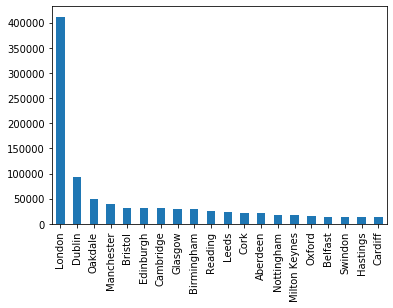

In [48]:
# df1['city'].value_counts().hist()
df1['city'].value_counts()[:20].plot.bar()

Top 20 occupation groups

In [ ]:
# define function to get venue information based on latitude and longitude
def getCityVenues(names, radius=1000, limit=100):
    venues_list = []
    c = 1
    for name in names:
        # get latitude and longitudes of the city
        address = name + ', CA'
#         if c 
        print(str(c) + ': ' + address)
        geolocator = Nominatim(user_agent="la_explorer", timeout=3)
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude

        # make the API call
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            limit)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # add venue name, location, category, and city
        venues_list.append([(
            name,
            latitude,
            longitude,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
        c += 1

    la_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    la_venues.columns = ['City',
                        'City latitude', 
                        'City longitude',
                        'Venue',
                        'Venue latitude',
                        'Venue longitude',
                        'Venue category']
    return la_venues

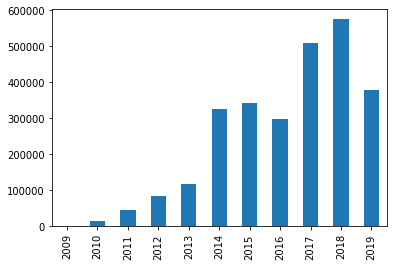

In [297]:
df1.index.year.value_counts().sort_index().plot.bar()

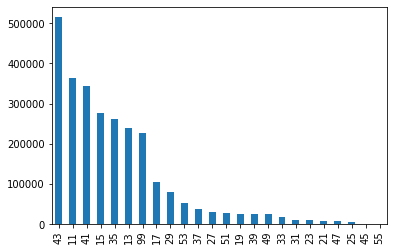

In [5]:
# DISTRUBTION OF JOBS BY ONET OCCUPATION FAMILY
df1['onet_fam'].value_counts().plot.bar();

In [266]:
df1.head()

,city,region,zip,delete_date,onet_occupation_code,SOC_occupation_code,t_delta,year,onet_fam,loc_x,loc_y
0,Aberdeen,Scotland,AB25,2014-12-16 15:58:17+00:00,51-8013.00,8124,6.0,2014,51,"[56.7861112, -4.1140518]","[56.7861112, -4.1140518]"
1,Aberdeen,Scotland,AB25,2014-04-08 19:27:57+00:00,15-1132.00,2136,90.0,2014,15,"[56.7861112, -4.1140518]","[56.7861112, -4.1140518]"
2,Aberdeen,Scotland,AB25,2019-07-30 08:26:00+00:00,41-1012.00,6212,4.0,2019,41,"[56.7861112, -4.1140518]","[56.7861112, -4.1140518]"
3,Aberdeen,Scotland,AB25,2019-05-09 03:47:00+00:00,37-2021.00,6132,29.0,2019,37,"[56.7861112, -4.1140518]","[56.7861112, -4.1140518]"
4,Aberdeen,Scotland,AB25,2014-08-26 20:45:52+00:00,11-9041.00,2150,2.0,2014,11,"[56.7861112, -4.1140518]","[56.7861112, -4.1140518]"
